In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PARÁMETROS DEL ROBOT: Definición Geométrica ---
# Estas constantes definen la morfología del manipulador RRR (Revolute-Revolute-Revolute).
# Representan las longitudes fijas de los eslabones según la convención cinemática.
L1 = 10  # Longitud del eslabón base a lo largo del eje Z₀.
L2 = 12  # Longitud del eslabón entre la articulación 1 (hombro) y 2 (codo).
L3 = 8  # Longitud del eslabón entre la articulación 2 (codo) y el efector final (pinza).

In [6]:
# --- 2. FUNCIONES DE CINEMÁTICA (ENFOQUE GEOMÉTRICO) ---

def forward_kinematics(thetas, lengths):
    """
    Resuelve el Problema Cinemático Directo (PCD) para un manipulador RRR.

    Teoría Matemática:
    El método consiste en una suma vectorial secuencial en el espacio euclidiano 3D. La posición
    cartesiana de cada articulación se determina a partir de la anterior mediante la aplicación
    de transformaciones de coordenadas, pasando de una representación de espacio articular
    (ángulos) a una representación de espacio cartesiano (x, y, z).
    """
    L1, L2, L3 = lengths
    theta1, theta2, theta3 = thetas

    # P₀: Origen del sistema de referencia inercial S₀.
    p0 = np.array([0, 0, 0])

    # P₁: Posición de la articulación 1 (Hombro).
    # Teoría: Se calcula mediante una traslación pura a lo largo del eje Z₀.
    # Fórmula: P₁ = P₀ + [0, 0, L₁]
    p1 = np.array([0, 0, L1])

    # P₂: Posición de la articulación 2 (Codo).
    # Teoría: Se calcula sumando a P₁ el vector del eslabón L₂. Las componentes de este
    # vector se obtienen descomponiendo su magnitud L₂ usando el ángulo azimutal (θ₁)
    # y el ángulo de elevación (θ₂).
    # r₂ es la proyección radial del eslabón L₂ sobre el plano X₀Y₀.
    r2 = L2 * np.cos(theta2)
    # x₂, y₂ son las componentes cartesianas de la proyección radial r₂.
    x2 = r2 * np.cos(theta1)
    y2 = r2 * np.sin(theta1)
    # z₂ es la altura total, sumando la componente vertical del eslabón L₂.
    z2 = L1 + L2 * np.sin(theta2)
    p2 = np.array([x2, y2, z2])

    # P₃: Posición del efector final (Pinza).
    # Teoría: La orientación del vector L₃ es relativa al eslabón L₂. Su ángulo
    # de elevación efectivo, medido desde la horizontal, es la suma θ₂ + θ₃.
    theta23 = theta2 + theta3
    # r₃ es la proyección radial del eslabón L₃.
    r3 = L3 * np.cos(theta23)
    # La posición final se obtiene sumando las proyecciones radiales (r₂ + r₃) y
    # descomponiendo el vector resultante con el ángulo azimutal θ₁.
    x3 = (r2 + r3) * np.cos(theta1)
    y3 = (r2 + r3) * np.sin(theta1)
    z3 = L1 + L2 * np.sin(theta2) + L3 * np.sin(theta23)
    p3 = np.array([x3, y3, z3])

    # Retorna el vector de posición cartesiana del efector final y la localización de todas las articulaciones.
    return p3, [p0, p1, p2, p3]


def inverse_kinematics(target_pos, lengths, elbow_config='up'):
    """
    Resuelve el Problema Cinemático Inverso (PCI) para un manipulador RRR.

    Teoría Matemática:
    El método se basa en el desacoplamiento cinemático. El problema 3D se descompone
    en un problema 2D en el plano vertical de operación del brazo, que se resuelve
    analíticamente mediante relaciones trigonométricas.
    """
    L1, L2, L3 = lengths
    x, y, z = target_pos

    # --- Cálculo de Theta 1 ---
    # Teoría: El ángulo de la base (θ₁) se determina por la proyección ortogonal del
    # punto objetivo sobre el plano X₀Y₀. Es un problema de conversión de coordenadas
    # cartesianas a polares, resuelto con la función arcotangente de dos argumentos.
    # Fórmula: θ₁ = atan2(y, x)
    theta1 = np.arctan2(y, x)

    # --- Reducción del problema de 3D a 2D ---
    # Teoría: Se define un nuevo marco de referencia 2D que rota con θ₁.
    # 'r' es la componente radial en el plano XY. 'z_prime' es la altura efectiva desde el hombro.
    r = np.sqrt(x ** 2 + y ** 2)
    z_prime = z - L1

    # 'd' es la distancia euclidiana directa entre la articulación del hombro (S₁) y el efector final (S₃).
    # Fórmula (Teorema de Pitágoras): d = √(r² + z'²)
    d = np.sqrt(r ** 2 + z_prime ** 2)

    # Validación del espacio de trabajo.
    # Teoría: Una solución cinemática existe si y solo si la distancia 'd' está contenida
    # en el anillo definido por el alcance máximo (L₂ + L₃) y mínimo (|L₂ - L₃|).
    if d > L2 + L3 or d < abs(L2 - L3):
        return None

    # --- Resolución del Triángulo Planar (L₂, L₃, d) ---
    # Teoría: Se aplica la Ley de los Cosenos para determinar los ángulos internos
    # del triángulo formado por los eslabones L₂ y L₃ y la distancia d.

    # α es el ángulo de elevación del vector 'd' respecto a la horizontal del plano de trabajo.
    # Fórmula: α = atan2(z', r)
    alpha = np.arctan2(z_prime, r)

    # β es el ángulo interno en la articulación del hombro (S₁), opuesto al eslabón L₃.
    # Fórmula (Ley de Cosenos): β = arccos((d² + L₂² - L₃²) / (2·d·L₂))
    beta_cos_val = (d ** 2 + L2 ** 2 - L3 ** 2) / (2 * d * L2)
    beta_cos_val = np.clip(beta_cos_val, -1.0, 1.0)
    beta = np.arccos(beta_cos_val)

    # Argumento del arccos para el ángulo del codo θ₃, opuesto al lado d.
    cos_theta3 = (d ** 2 - L2 ** 2 - L3 ** 2) / (2 * L2 * L3)
    cos_theta3 = np.clip(cos_theta3, -1.0, 1.0)

    # Determinación de la solución cinemática.
    # Teoría: El PCI para este manipulador admite dos soluciones, que se distinguen
    # por la orientación del codo y afectan a los signos de θ₂ y θ₃.
    if elbow_config == 'up':
        # Configuración "codo arriba":
        # Fórmula: θ₂ = α + β ; θ₃ = -arccos(...)
        theta2 = alpha + beta
        theta3 = -np.arccos(cos_theta3)
    else:  # 'down'
        # Configuración "codo abajo":
        # Fórmula: θ₂ = α - β ; θ₃ = +arccos(...)
        theta2 = alpha - beta
        theta3 = np.arccos(cos_theta3)

    return [theta1, theta2, theta3]

In [7]:
# --- 3. FUNCIONES DE VISUALIZACIÓN ---

def plot_arm(joint_positions, target=None):
    """
    Genera una representación gráfica de la configuración cinemática del robot
    en un espacio cartesiano 3D para la validación visual de los resultados.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    points = np.array(joint_positions)
    # Dibujo de la cadena cinemática (eslabones y articulaciones)
    ax.plot(points[:, 0], points[:, 1], points[:, 2], '-', color='purple', lw=4, label='Eslabones', zorder=1)
    ax.scatter(points[:-1, 0], points[:-1, 1], points[:-1, 2], c='blue', s=100, label='Articulaciones', zorder=2)
    # Representación visual de la articulación final y el punto objetivo
    final_joint = points[-1]
    ax.scatter(final_joint[0], final_joint[1], final_joint[2], s=350, facecolors='none', edgecolors='darkviolet', lw=2, zorder=4)
    if target is not None:
        ax.scatter(target[0], target[1], target[2], c='gold', s=250, marker='*', label='Objetivo', zorder=3, edgecolor='black')
    # Configuración del entorno gráfico
    ax.set_xlabel('Eje X (m)'), ax.set_ylabel('Eje Y (m)'), ax.set_zlabel('Eje Z (m)')
    ax.set_title('Simulador Robótico 3-DOF (Enfoque Geométrico)')
    max_range = L1 + L2 + L3
    ax.set_xlim([-max_range, max_range]), ax.set_ylim([-max_range, max_range]), ax.set_zlim([0, max_range])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels), ax.grid(True)
    plt.show()


--- RESULTADO CINEMÁTICA DIRECTA ---
Para los ángulos articulares: [40, 60, -50]°
La posición cartesiana del efector final es: (x=10.632, y=8.921, z=21.781)

--- VISUALIZACIÓN DE CINEMÁTICA DIRECTA ---


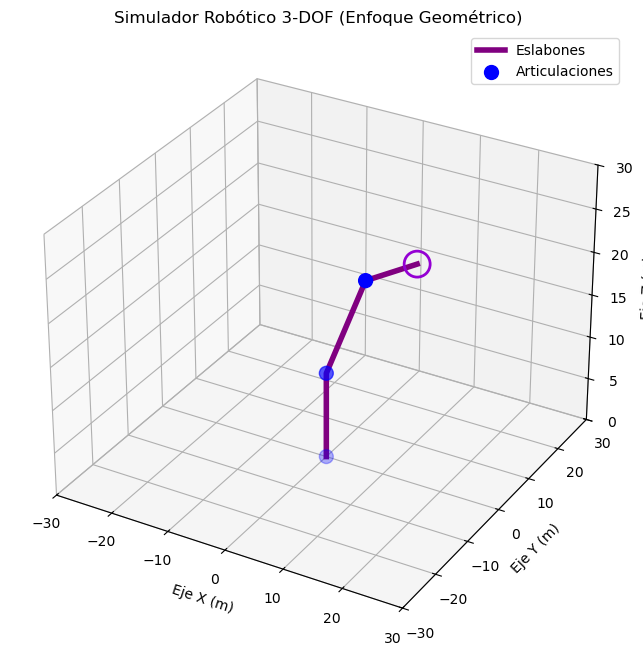



--- RESULTADO CINEMÁTICA INVERSA ---
Para la posición objetivo: (x=10.632, y=8.921, z=21.781)
Los ángulos articulares calculados son: (θ1=40.000°, θ2=60.000°, θ3=-50.000°)
VERIFICACIÓN: La posición alcanzada es (x=10.632, y=8.921, z=21.781)

--- VISUALIZACIÓN DE CINEMÁTICA INVERSA - VERIFICACIÓN ---


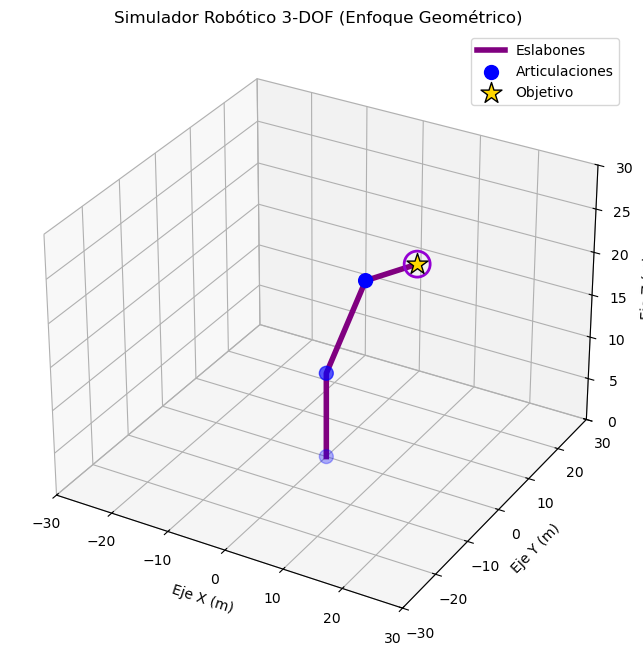

In [8]:
# --- 4. EJECUCIÓN Y VALIDACIÓN ALGORÍTMICA ---

if __name__ == "__main__":

    # --- Prueba del Problema Cinemático Directo (PCD) ---
    # Se proporciona un vector de configuración articular Θ = [θ₁, θ₂, θ₃]
    # para calcular el vector de posición cartesiana resultante P = [x, y, z].
    angles_deg = [40, 60, -50]
    angles_rad = [np.deg2rad(angle) for angle in angles_deg]

    final_pos, all_joints = forward_kinematics(angles_rad, [L1, L2, L3])

    print("--- RESULTADO CINEMÁTICA DIRECTA ---")
    print(f"Para los ángulos articulares: {angles_deg}°")
    print(
        f"La posición cartesiana del efector final es: (x={final_pos[0]:.3f}, y={final_pos[1]:.3f}, z={final_pos[2]:.3f})")
    print("\n--- VISUALIZACIÓN DE CINEMÁTICA DIRECTA ---")
    plot_arm(all_joints)

    print("\n" + "=" * 50 + "\n")

    # --- Prueba del Problema Cinemático Inverso (PCI) ---
    # Se utiliza la posición P obtenida del PCD como el objetivo para verificar
    # la consistencia y exactitud del algoritmo de cinemática inversa.
    target_position = final_pos

    # El PCI debe encontrar un vector de configuración Θ' que sea idéntico al Θ original.
    target_angles = inverse_kinematics(target_position, [L1, L2, L3], elbow_config='up')

    print("--- RESULTADO CINEMÁTICA INVERSA ---")
    print(
        f"Para la posición objetivo: (x={target_position[0]:.3f}, y={target_position[1]:.3f}, z={target_position[2]:.3f})")
    if target_angles:
        target_angles_deg = [np.rad2deg(angle) for angle in target_angles]
        print(
            f"Los ángulos articulares calculados son: (θ1={target_angles_deg[0]:.3f}°, θ2={target_angles_deg[1]:.3f}°, θ3={target_angles_deg[2]:.3f}°)")

        # Verificación final: Se aplica la PCD a los ángulos resultantes de la PCI.
        final_pos_ik, all_joints_ik = forward_kinematics(target_angles, [L1, L2, L3])
        print(
            f"VERIFICACIÓN: La posición alcanzada es (x={final_pos_ik[0]:.3f}, y={final_pos_ik[1]:.3f}, z={final_pos_ik[2]:.3f})")

        print("\n--- VISUALIZACIÓN DE CINEMÁTICA INVERSA - VERIFICACIÓN ---")
        plot_arm(all_joints_ik, target=target_position)